# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [3]:
# %pip install tensorflow --upgrade
# %pip install keras --upgrade
#%pip install scikit-image
import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.utils import to_categorical

%matplotlib inline

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/12.7 MB ? eta -:--:--
                                              0.3/12.7 MB 6.5 MB/s eta 0:00:02
     --                                       0.9/12.7 MB 9.4 MB/s eta 0:00:02
     ----                                     1.5/12.7 MB 11.9 MB/s eta 0:00:01
     -------                                  2.3/12.7 MB 12.4 MB/s eta 0:00:01
     ----------                               3.3/12.7 MB 14.2 MB/s eta 0:00:01
     -------------                            4.3/12.7 MB 15.4 MB/s eta 0:00:01
     ----------------                         5.4/12.7 MB 15.7 MB/s eta 0:00:01
     --------------------                     6.6/12.7 MB 16.9 MB/s eta 0:00:01
     ------------------------                 7.9/12.7 MB 17.9 MB/s eta 0:00:01
     -----------------------------            9.4/12.7 MB 19.4 MB/s eta 0:00:01
     --------------------------------        10.7/12.7 MB 21.8 MB/s eta 0:00:01
     -------------------------------------   12.2/

Load the `mnist` dataset and normalize in the range [0, 1]

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [5]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [6]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

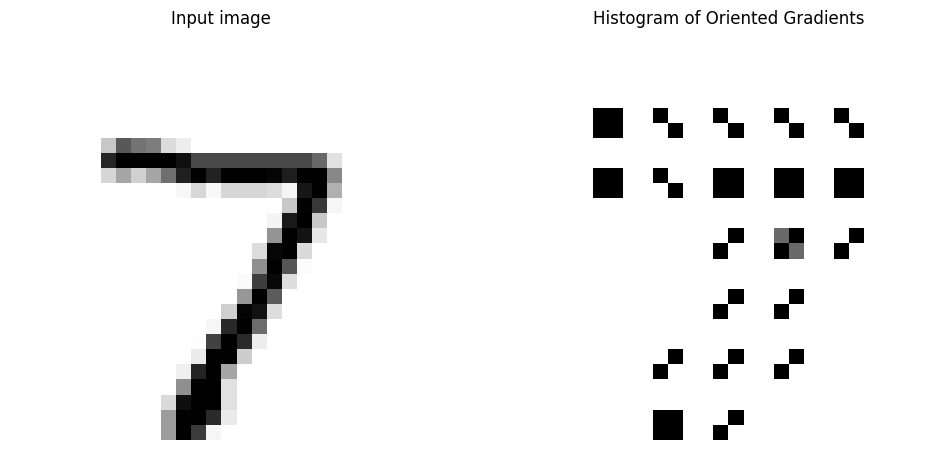

In [7]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets


In [8]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [9]:
model = Sequential()
model.add(Dense(2, input_shape=(hog_size,), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

c:\Users\Jarod\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │           786 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 816 (3.19 KB)

 Trainable params: 816 (3.19 KB)

 Non-trainable params: 0 (0.00 B)

Define some constants and train the MLP

In [10]:
batch_size = 128
n_epoch = 3

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2105 - loss: 2.0991 - val_accuracy: 0.2935 - val_loss: 1.6770
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3523 - loss: 1.6190 - val_accuracy: 0.4888 - val_loss: 1.4160
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4926 - loss: 1.3871 - val_accuracy: 0.5198 - val_loss: 1.2348


Show the performance of the model

Test score: 1.2456306219100952
Test accuracy: 0.507099986076355


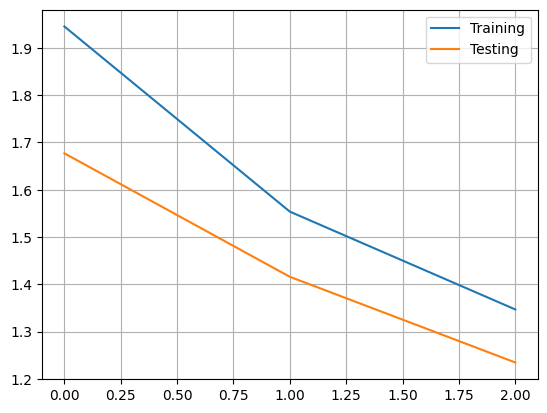

In [11]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [12]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


array([[738,   1,   6,  19,   1,  37, 147,   1,  25,   5],
       [  0, 242,  45, 165,   0,   2,   0, 659,  21,   1],
       [  2,   2, 903,   7,   0,   3,   0,  58,  57,   0],
       [ 32,  96, 134, 392,   1,  11,   2, 247,  80,  15],
       [727,   5,   9, 128,   3,   6,  10,   3,  20,  71],
       [ 20,   0,  21,   6,   0, 377, 155,   1, 312,   0],
       [  5,   0,   0,   0,   0,  31, 919,   0,   3,   0],
       [  3,  39,  54,  86,   0,   0,   0, 838,   2,   6],
       [ 13,   0, 160,  14,   0, 199,  51,   3, 534,   0],
       [625,  16,   8, 211,   0,   3,   2,   9,  10, 125]], dtype=int64)